In [1]:
# Necessary imports

from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

In [2]:
# Acquire the data and take a look

df = pd.read_csv('anonymized-curriculum-access.txt.gz', compression='gzip', header=None, sep=' ', quotechar='"', error_bad_lines=False)
df

,0,1,2,3,4,5
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
900218,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
900219,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
900220,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33
900221,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


In [3]:
# Rename the columns into something meaningful for readability

df = df.rename(columns={0:'date', 
                           1:'time', 2:'webpage_accessed', 
                           3:'user_id',
                           4:'cohort_id', 
                           5:'ip_address'})

In [4]:
# Convert 'date' and 'time' into datetime and make that the index

df.index = pd.to_datetime(df.date + " " + df.time)
df

,date,time,webpage_accessed,user_id,cohort_id,ip_address
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61
...,...,...,...,...,...,...
2021-04-21 16:41:51,2021-04-21,16:41:51,jquery/personal-site,64,28.0,71.150.217.33
2021-04-21 16:42:02,2021-04-21,16:42:02,jquery/mapbox-api,64,28.0,71.150.217.33
2021-04-21 16:42:09,2021-04-21,16:42:09,jquery/ajax/weather-map,64,28.0,71.150.217.33
2021-04-21 16:44:37,2021-04-21,16:44:37,anomaly-detection/discrete-probabilistic-methods,744,28.0,24.160.137.86


In [5]:
# Figure out the size and datatypes

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 900223 entries, 2018-01-26 09:55:03 to 2021-04-21 16:44:39
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   date              900223 non-null  object 
 1   time              900223 non-null  object 
 2   webpage_accessed  900222 non-null  object 
 3   user_id           900223 non-null  int64  
 4   cohort_id         847330 non-null  float64
 5   ip_address        900223 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 48.1+ MB


In [6]:
# Where are my nulls

df.isnull().sum()

date                    0
time                    0
webpage_accessed        1
user_id                 0
cohort_id           52893
ip_address              0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
# Start looking at cohort_id and user_id

df.groupby(['cohort_id', 'user_id']).webpage_accessed.agg('count')

cohort_id  user_id
1.0        11         2735
           60          517
           64         3767
           95            9
           141           9
                      ... 
139.0      975          67
           976          29
           977          86
           978          55
           979         127
Name: webpage_accessed, Length: 952, dtype: int64

In [9]:
# Find out count by cohort

df.cohort_id.value_counts()

28.0     84031
33.0     40730
29.0     38096
62.0     37109
53.0     36902
24.0     35636
57.0     33844
56.0     33568
51.0     32888
59.0     32015
22.0     30926
58.0     29855
32.0     29356
23.0     28534
52.0     28033
26.0     27749
34.0     26538
25.0     25586
31.0     25359
132.0    23691
55.0     21581
27.0     20743
61.0     17713
134.0    16623
135.0    16397
133.0    14715
14.0      9587
1.0       8890
137.0     8562
21.0      7444
138.0     7276
17.0      4954
13.0      2845
18.0      2158
8.0       1712
139.0     1672
19.0      1237
16.0       755
15.0       691
7.0        598
12.0       302
11.0       253
2.0         93
6.0         72
9.0          5
4.0          4
5.0          1
Name: cohort_id, dtype: int64

In [10]:
# Create a 'day' column

df['day'] = df.index.day_name()
df.head()

,date,time,webpage_accessed,user_id,cohort_id,ip_address,day
2018-01-26 09:55:03,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,Friday
2018-01-26 09:56:02,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,Friday
2018-01-26 09:56:05,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,Friday
2018-01-26 09:56:06,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,Friday
2018-01-26 09:56:24,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61,Friday


In [11]:
# See how many observations occur on a given day of the week

df.day.value_counts().sort_values(ascending=False)

Monday       174418
Tuesday      169530
Thursday     153249
Wednesday    145507
Friday       127384
Sunday        45221
Saturday      32020
Name: day, dtype: int64

In [12]:
# 

pd.crosstab(df.ip_address, df.day)

day,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
ip_address,,,,,,,
100.11.170.135,10,30,0,0,33,39,2
100.19.73.35,64,73,2,11,90,101,67
100.35.67.162,0,0,0,11,0,0,0
103.137.12.164,0,0,0,0,9,0,0
104.1.46.153,3,5,0,0,0,0,3
...,...,...,...,...,...,...,...
99.97.210.12,12,0,0,0,6,0,0
99.98.245.245,0,0,0,0,0,2,0
99.98.32.165,79,43,45,26,24,25,25


In [13]:
# User 11 is active with the curriculum

df.groupby(['user_id']).webpage_accessed.agg('count').sort_values(ascending=False)

user_id
11     17913
64     16322
53     12329
314     7783
1       7404
       ...  
163        1
165        1
918        1
212        1
879        1
Name: webpage_accessed, Length: 911, dtype: int64

In [14]:
# 

df.groupby(['webpage_accessed']).cohort_id.agg('count').sort_values(ascending=False)

webpage_accessed
/                               45854
javascript-i                    18203
toc                             17591
search/search_index.json        17534
java-iii                        13166
                                ...  
end_to_end_clustering               1
essential-methods/traversing        1
evaluate                            1
examples/bootstrap/pizza.pn         1
wp-login                            1
Name: cohort_id, Length: 2224, dtype: int64

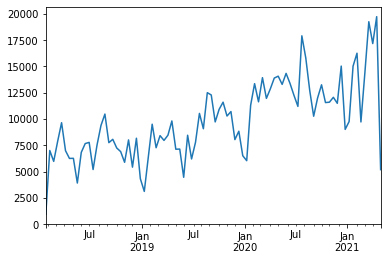

In [17]:
df.resample('2W').webpage_accessed.agg('count').plot()

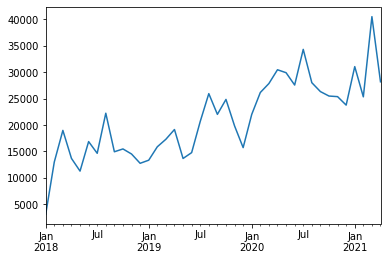

In [15]:
df.resample('M').user_id.agg('count').plot()

In [21]:
# Between the hours of midnight and 6am 

df[(df.index.hour > 0) & (df.index.hour < 6)]

,date,time,webpage_accessed,user_id,cohort_id,ip_address,day
2018-01-27 02:05:02,2018-01-27,02:05:02,examples/css/bootstrap-grids.html,12,22.0,76.185.247.126,Saturday
2018-01-27 02:12:02,2018-01-27,02:12:02,/,50,13.0,24.26.254.147,Saturday
2018-01-27 04:49:33,2018-01-27,04:49:33,html-css/introduction,22,21.0,107.204.132.6,Saturday
2018-01-27 04:49:36,2018-01-27,04:49:36,spring,22,21.0,107.204.132.6,Saturday
2018-01-27 04:58:36,2018-01-27,04:58:36,spring/fundamentals/controllers,22,21.0,107.204.132.6,Saturday
...,...,...,...,...,...,...,...
2021-04-21 01:52:59,2021-04-21,01:52:59,timeseries/modeling-lesson1,838,133.0,99.158.249.67,Wednesday
2021-04-21 03:16:21,2021-04-21,03:16:21,javascript-i/javascript-with-html,966,139.0,136.50.72.144,Wednesday
2021-04-21 03:31:44,2021-04-21,03:31:44,javascript-i/functions,966,139.0,136.50.72.144,Wednesday
2021-04-21 05:24:53,2021-04-21,05:24:53,javascript-i/conditionals,966,139.0,136.50.72.144,Wednesday


In [25]:
# Between the hours of midnight and 6am

df[(df.index.hour > 0) & (df.index.hour < 6)].value_counts()

date        time      webpage_accessed                                user_id  cohort_id  ip_address      day      
2020-08-04  04:39:40  /                                               580      55.0       74.192.167.159  Tuesday      4
2020-06-20  02:41:36  toc                                             570      53.0       136.49.100.118  Saturday     2
2019-10-18  04:54:06  mysql                                           438      33.0       67.11.215.97    Friday       2
2020-06-20  02:41:41  appendix/professional-development/cover-letter  570      53.0       136.49.100.118  Saturday     2
2020-08-16  01:56:21  java-i/syntax-types-and-variables               662      58.0       148.66.39.89    Sunday       2
                                                                                                                      ..
2019-08-30  05:53:53  2-storytelling/2.2-create                       483      34.0       67.11.120.157   Friday       1
            05:41:34  2-storytelling/